# Importing libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
import pillow_heif
from sklearn.preprocessing import normalize
import matplotlib.patches as mpatches
from skfuzzy import membership 
from skimage.feature import graycomatrix, graycoprops
from scipy.fftpack import dct
from scipy import stats
import pywt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,roc_curve, auc,recall_score,precision_score
from sklearn.feature_selection import SelectFromModel
import pickle

# ROI Extraction

### Assigning variables to th Path to Data

In [155]:
Original="/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Original/"
Display = "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Spoofed_displayClicked/Display_jpeg/"
Paper = "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Spoofed_print/JPEG/"

Note: For ROI of original image consider resize size of +150,-150 and for Page and Display take +300,-300

### Extract ROI and save the images in respective folders

In [ ]:
map_old_path_var = {'Original': Original,'Display':Display,'Paper':Paper}
for _,p in map_old_path_var:
    files = os.listdir(p)
    for fi in files:
        if fi.endswith(".jpeg") or fi.endswith('.jpg')or fi.endswith(".JPG"): # USE _1.JPG for org images, .jpeg for diaplay images
            img_original = cv2.imread(p+fi) # Change var name
            h, w,_ = img_original.shape # equalized.shape
            img_o = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
            img_o = img_o[int(h-0.55*h):int(h),int(0.25*w):int(w-0.25*w)]
            h, w = img_o.shape 
            
            mask = cv2.threshold(img_o,200,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
            kernel = np.ones((3,3), np.uint8)

            mask **= cv2.GaussianBlur(mask, (0,0), sigmaX=2.29, sigmaY=2.29, borderType = cv2.BORDER_REPLICATE)
            mask = (2*(mask.astype(np.float32))-255).clip(0,250).astype(np.uint8) #hide for print spoof generation
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

            img_o = cv2.GaussianBlur(mask,(3,3),0)
            
            img_c = cv2.cvtColor(img_o, cv2.COLOR_GRAY2BGR)
            cntrs, _ = cv2.findContours(img_c, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            biggest_area = -1
            biggest = None

            for cnt in cntrs:
                area = cv2.contourArea(cnt)
                if biggest_area < area:
                    biggest_area = area
                    biggest = cnt
            cntrs = biggest

            epsilon = 0.0000000000000000000000000000001*cv2.arcLength(cntrs,True)
            approx = cv2.approxPolyDP(cntrs,epsilon,True)

            M = cv2.moments(approx)
            h, w = img_o.shape
            x_c = M['m10'] // M['m00']
            y_c = M['m01'] // M['m00']
            
            if p=='/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Original/':
                roi = img_o[int(y_c-150):int(y_c+150),int(x_c-150):int(x_c+150)]#change for Original to +-150 and for Paper/Display to +- 300
            else:
                roi = img_o[int(y_c-300):int(y_c+300),int(x_c-300):int(x_c+300)]
            roi = cv2.resize(roi,(150,150))# uncomment for paper and display
            if p=='/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Original/':
                cv2.imwrite(f"/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/interm_data/Original/"+fi, roi)
                
            elif p=='/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Spoofed_displayClicked/Display_jpeg/':
                cv2.imwrite(f"/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/interm_data/Display/"+fi, roi)
                
            elif p=='/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Spoofed_print/JPEG/':
                cv2.imwrite(f"/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/interm_data/Paper/"+fi, roi)

### Convert the images to greyscale and resize to 150x150

In [ ]:
map_interm_path_var = ['Original','Paper','Display']

for new_var in map_interm_path_var: 
    files = os.listdir(f'/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Data_with_new_code/{new_var}/')
    for fi in files:
        if fi.endswith(".jpeg") or fi.endswith('.jpg') or fi.endswith(".JPG"): # USE _1.JPG for org images, .jpeg for diaplay images
            n_img = cv2.imread(f'/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Data_with_new_code/{new_var}/'+fi)
            gray = cv2.cvtColor(n_img, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            equalized = clahe.apply(gray)
            roi = cv2.resize(equalized,(150,150))
            cv2.imwrite(f"/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Data_with_new_code/{new_var}/"+fi, roi)


# Feature Extraction

In [162]:
def img_skew(img):
    h,w = img.shape
    mean = img.mean()
    var = img.var()
    sk = 0
    for i in range(h):
        for j in range(w):
            sk+= ((img[i,j]-mean)**3)
    return sk/((w*h)*((var)*(2/3)))

def img_kurto(img):
    h,w = img.shape
    mean = img.mean()
    var = img.var()
    kurto = 0
    for i in range(h):
        for j in range(w):
            kurto += ((img[i,j]-mean)**4)
    return kurto/((h*w)*((var)**2))

def split_img(img, N,A):
    test = img.reshape(75,75)
    split_test = test[0:N-N%A, 0:N-N%A].reshape(N//A, A, -1, A).swapaxes(1, 2).reshape(-1, A, A)
    return split_test


In [ ]:
levels = 256

map_new_path_var = ['Original','Paper','Display']

pca = PCA(n_components=2)
for p in map_new_path_var:
    df = pd.DataFrame() 
    files = os.listdir(p)
    for h,fi in enumerate(files):
        features = {}
        if fi.endswith(".jpeg") or fi.endswith(".jpg") or fi.endswith(".JPG"):#.JPG for org and .jpeg for display
            img = cv2.imread(f"/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Data_with_new_code/{p}/"+fi,cv2.IMREAD_GRAYSCALE) #change path
            #Statistical Features
            features['mean'] = [img.mean()]
            features['pixel_intensity_variance'] = [img.var()]
            features['10th_percentile'] = [np.percentile(img, 10)]
            features['50th_percentile'] = [np.percentile(img, 50)]
            features['90th_percentile'] = [np.percentile(img, 90)]
            features['skewness'] = [img_skew(img)]
            features['kurtosis'] = [img_kurto(img)]
            features['median'] = [np.median(img)]
            features['mode'] = [stats.mode(img, axis=None, keepdims=True)[0][:]]
            
            #GLCM features
            glcm = graycomatrix(img, distances=[1], angles=[0], levels=levels,symmetric=True, normed=True)
            features['contrast'] = [graycoprops(glcm, 'contrast')[0][0]]
            features['correlation'] = [graycoprops(glcm, 'correlation')[0][0]]
            features['energy']= [graycoprops(glcm, 'energy')[0][0]]
            features['homogeneity']= [graycoprops(glcm, 'homogeneity')[0][0]]
            features['entropy']= [graycoprops(glcm, 'homogeneity')[0][0]]
            
            #DWT coeff.
            dwt = pywt.dwt2(img, 'db1')
            LL, (LH,HL,HH) = dwt
            ll_split = split_img(LL,75,25)
            lh_split = split_img(LH,75,15)
            hl_split = split_img(HL,75,15)
            hh_split = split_img(HH,75,15)
            
            for k,i in enumerate(ll_split):
                features['ll_dct'+'_explained_variance_ratio_'+str(k)+"_0"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[0]]
                features['ll_dct'+'_explained_variance_ratio_'+str(k)+"_1"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[1]]
                features['ll_dct'+'_singular_values_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).singular_values_[0]]
                features['ll_dct'+'_singular_values_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).singular_values_[1]]
            
            for k,i in enumerate(lh_split):
                features['lh_dct'+'_explained_variance_ratio_'+str(k)+"_0"]=[ pca.fit(dct(i, 1)).explained_variance_ratio_[0]]
                features['lh_dct'+'_explained_variance_ratio_'+str(k)+"_1"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[1]]
                features['lh_dct'+'_singular_values_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).singular_values_[0]]
                features['lh_dct'+'_singular_values_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).singular_values_[1]]
                
            for k,i in enumerate(hl_split):
                features['hl_dct'+'_explained_variance_ratio_'+str(k)+"_0"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[0]]
                features['hl_dct'+'_explained_variance_ratio_'+str(k)+"_1"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[1]]
                features['hl_dct'+'_singular_values_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).singular_values_[0]]
                features['hl_dct'+'_singular_values_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).singular_values_[1]]
                
            for k,i in enumerate(hh_split):
                features['hh_dct'+'_explained_variance_ratio_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).explained_variance_ratio_[0]]
                features['hh_dct'+'_explained_variance_ratio_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).explained_variance_ratio_[1]]
                features['hh_dct'+'_singular_values_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).singular_values_[0]]
                features['hh_dct'+'_singular_values_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).singular_values_[1]]
            df_t = pd.DataFrame(features)
            if new_var == 'Original':
                df_t['Class'] = 1
            elif new_var == 'Paper':
                df_t['Class'] = 0
            elif new_var == 'Display':
                df_t['Class'] = 0
        df = pd.concat([df,df_t], ignore_index=True)
    df.to_csv(f'/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/{new_var}_new.csv',index=False)
    
    # 0 = negative Class => Spoofed => Display & Paper. 1 = Positive Class => Original

# Training

In [214]:
df1 = pd.read_csv("/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Original_new.csv")
df2 = pd.read_csv("/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Display_new.csv")
df3 = pd.read_csv('/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/Paper_new.csv')

In [215]:
samples_from_d2 = df1.shape[0]-df3.shape[0]
print(samples_from_d2)

117


In [216]:
new_df2 = df2.sample(n=samples_from_d2,ignore_index=True)
df_class1 = pd.concat([df3, new_df2], ignore_index=True).sample(frac=1, random_state=1).reset_index()
df_main = pd.concat([df1, df_class1], ignore_index=True).sample(frac=1, random_state=1).reset_index()

In [217]:
df_main.head()

,level_0,mean,pixel_intensity_variance,10th_percentile,50th_percentile,90th_percentile,skewness,kurtosis,median,mode,...,hh_dct_explained_variance_ratio_23_0,hh_dct_explained_variance_ratio_23_1,hh_dct_singular_values_23_0,hh_dct_singular_values_23_1,hh_dct_explained_variance_ratio_24_0,hh_dct_explained_variance_ratio_24_1,hh_dct_singular_values_24_0,hh_dct_singular_values_24_1,Class,index
0,330,190.697778,827.773728,151.0,194.0,226.0,-19.947418,2.759805,194.0,209,...,0.347871,0.218072,84.671026,67.038790,0.364579,0.270135,96.171906,82.783295,0,119.0
1,101,159.260622,1642.545943,112.0,171.0,196.0,-100.579346,5.555284,171.0,183,...,0.360795,0.211192,84.005942,64.271563,0.324604,0.222053,109.006644,90.158035,1,NaN
2,191,165.415600,1716.638610,92.0,176.0,202.0,-99.996644,5.137681,176.0,182,...,0.270971,0.211413,78.213172,69.085174,0.366719,0.228892,139.923022,110.544534,1,NaN
3,66,165.059244,1288.506757,116.0,173.0,204.0,-57.760729,4.283456,173.0,182,...,0.372888,0.141395,92.394963,56.895144,0.240813,0.212118,75.115018,70.497816,1,NaN
4,326,205.951111,622.812099,171.0,210.5,234.0,-32.518063,3.527848,210.5,232,...,0.231890,0.187234,72.735569,65.358012,0.280693,0.237536,58.112502,53.458679,0,220.0


In [218]:
df_main = df_main.drop(['index','level_0'],axis=1)

In [219]:
df_main.head()

,mean,pixel_intensity_variance,10th_percentile,50th_percentile,90th_percentile,skewness,kurtosis,median,mode,contrast,...,hh_dct_singular_values_22_1,hh_dct_explained_variance_ratio_23_0,hh_dct_explained_variance_ratio_23_1,hh_dct_singular_values_23_0,hh_dct_singular_values_23_1,hh_dct_explained_variance_ratio_24_0,hh_dct_explained_variance_ratio_24_1,hh_dct_singular_values_24_0,hh_dct_singular_values_24_1,Class
0,190.697778,827.773728,151.0,194.0,226.0,-19.947418,2.759805,194.0,209,34.209128,...,67.150725,0.347871,0.218072,84.671026,67.038790,0.364579,0.270135,96.171906,82.783295,0
1,159.260622,1642.545943,112.0,171.0,196.0,-100.579346,5.555284,171.0,183,49.724474,...,71.641063,0.360795,0.211192,84.005942,64.271563,0.324604,0.222053,109.006644,90.158035,1
2,165.415600,1716.638610,92.0,176.0,202.0,-99.996644,5.137681,176.0,182,40.621566,...,63.063701,0.270971,0.211413,78.213172,69.085174,0.366719,0.228892,139.923022,110.544534,1
3,165.059244,1288.506757,116.0,173.0,204.0,-57.760729,4.283456,173.0,182,100.680045,...,82.019914,0.372888,0.141395,92.394963,56.895144,0.240813,0.212118,75.115018,70.497816,1
4,205.951111,622.812099,171.0,210.5,234.0,-32.518063,3.527848,210.5,232,22.493781,...,54.110500,0.231890,0.187234,72.735569,65.358012,0.280693,0.237536,58.112502,53.458679,0


In [220]:
X,y = df_main.drop(['Class'], axis=1), df_main['Class'] 

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3928)

In [222]:
X_val, X_test, y_val, y_test =  train_test_split(X_test, y_test, test_size=0.3, random_state=694833)

# Training

## SVM

In [223]:
clf = svm.SVC(kernel='poly',C=(10**100),gamma=0.005)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [224]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))
print("ROC AUC score:",metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.8571428571428571
Precision: 0.7647058823529411
Recall: 0.9285714285714286
F1 score: 0.8387096774193549
ROC AUC score: 0.8690476190476191


[[17  4]
 [ 1 13]]


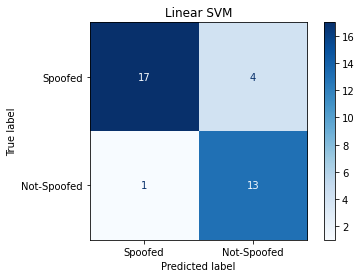

In [225]:
disp = ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test,display_labels=['Spoofed','Not-Spoofed'],cmap=plt.cm.Blues)
disp.ax_.set_title('Linear SVM')    
print(disp.confusion_matrix)

### Saving the model

In [ ]:
filename = 'svm_model_new_85p.sav'
pickle.dump(clf, open('/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/New_Saved_models/'+filename, 'wb'))

## XGBoost

In [227]:
columns = list(df_main.columns)[:-1]

In [228]:
evaluation_set = [(X_test, y_test)]

In [229]:
model = XGBClassifier( scale_pos_weight=1,
                      learning_rate=0.045,  
                      colsample_bytree = 1,
                      subsample = 0.3,
                      objective='reg:squarederror', 
                      n_estimators=9500, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=5,
                      early_stopping_rounds=10)

In [230]:
model.fit(X_train, y_train.values.ravel(),eval_set=evaluation_set)

[0]	validation_0-rmse:0.49321
[1]	validation_0-rmse:0.48455
[2]	validation_0-rmse:0.47576
[3]	validation_0-rmse:0.46678
[4]	validation_0-rmse:0.45842
[5]	validation_0-rmse:0.45197
[6]	validation_0-rmse:0.44267
[7]	validation_0-rmse:0.43668
[8]	validation_0-rmse:0.43045
[9]	validation_0-rmse:0.42977
[10]	validation_0-rmse:0.42351
[11]	validation_0-rmse:0.41686
[12]	validation_0-rmse:0.41184
[13]	validation_0-rmse:0.40676
[14]	validation_0-rmse:0.40362
[15]	validation_0-rmse:0.39840
[16]	validation_0-rmse:0.39404
[17]	validation_0-rmse:0.39432
[18]	validation_0-rmse:0.38979
[19]	validation_0-rmse:0.38925
[20]	validation_0-rmse:0.38771
[21]	validation_0-rmse:0.38779
[22]	validation_0-rmse:0.38513
[23]	validation_0-rmse:0.38512
[24]	validation_0-rmse:0.38515
[25]	validation_0-rmse:0.38521
[26]	validation_0-rmse:0.38537
[27]	validation_0-rmse:0.38029
[28]	validation_0-rmse:0.38049
[29]	validation_0-rmse:0.38047
[30]	validation_0-rmse:0.38062
[31]	validation_0-rmse:0.38041
[32]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.045, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=9500, n_jobs=0,
              num_parallel_tree=1, objective='reg:squarederror',
              predictor='auto', ...)

In [231]:
y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]

In [232]:
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.95%


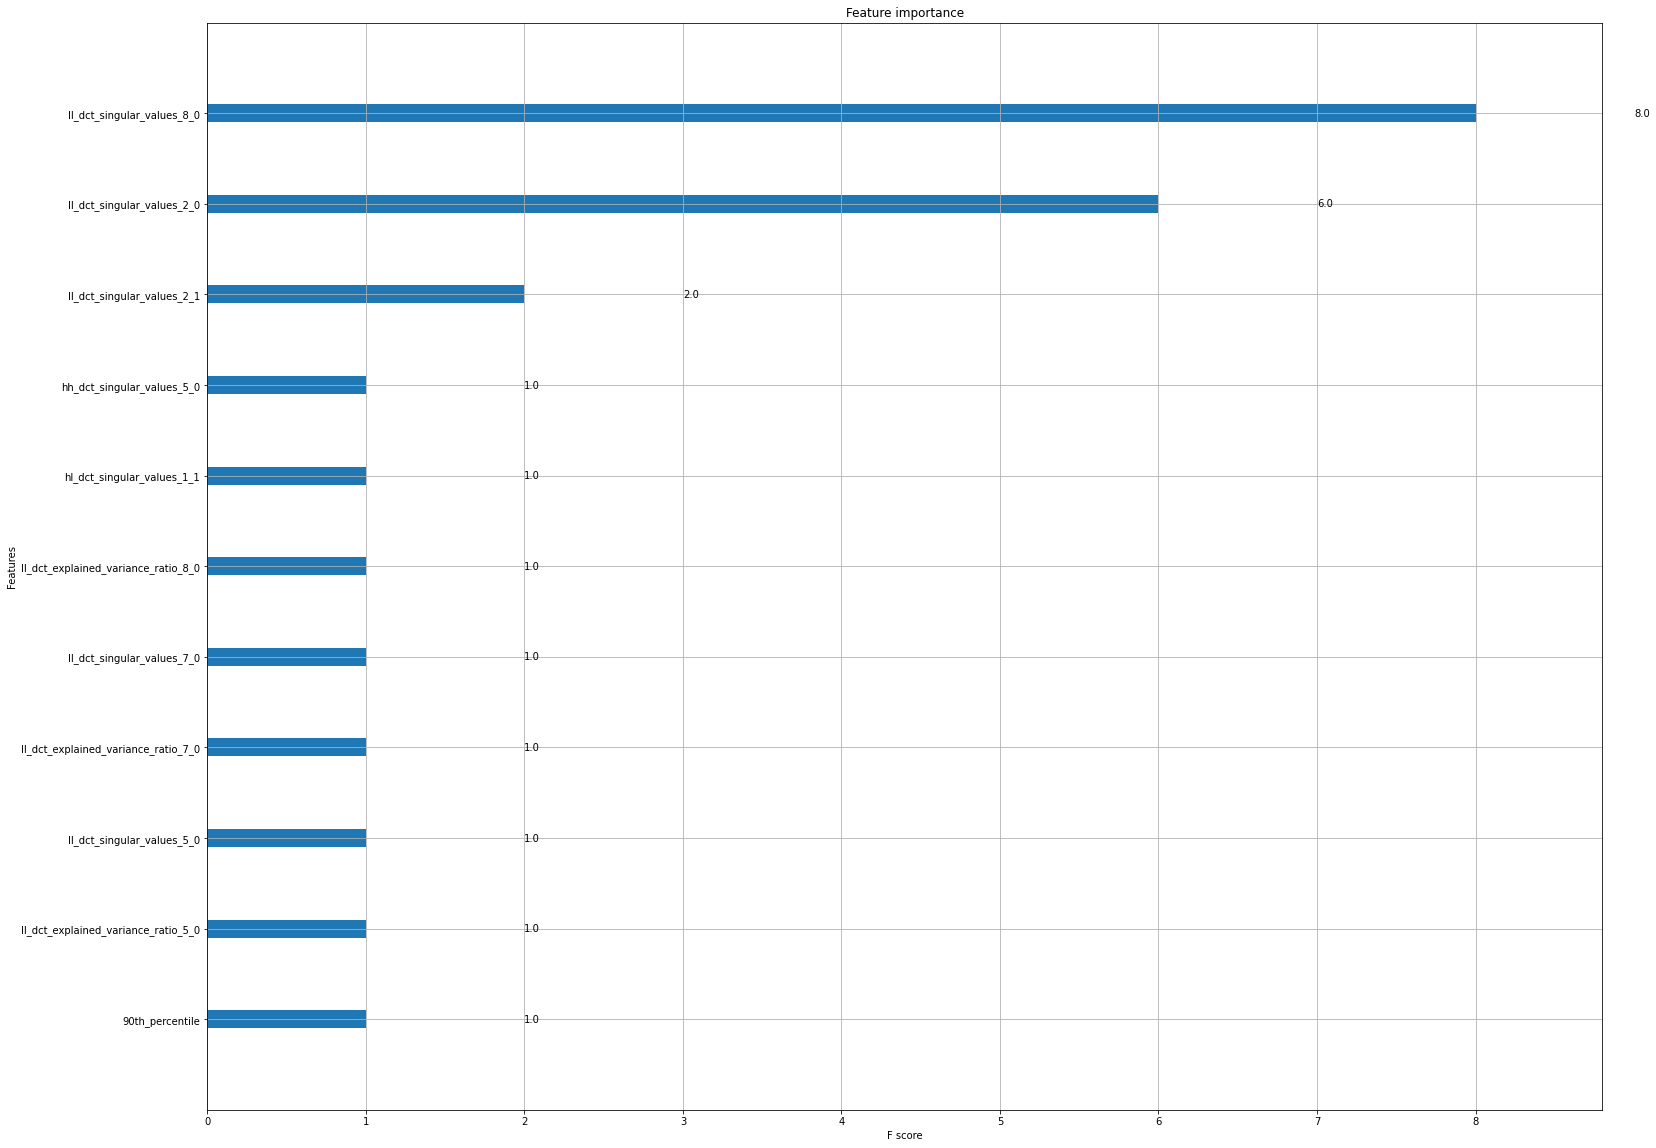

In [233]:
f,a = plt.subplots(figsize=(25,20))
plot_importance(model,ax=a)
plt.show()

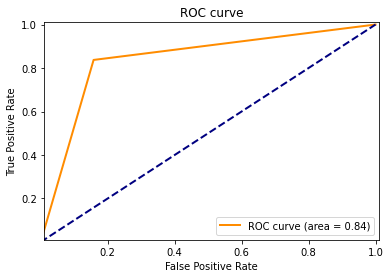

In [234]:
fpr, tpr, _ = roc_curve(y_val, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.01, 1.01])
plt.ylim([0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [235]:
model.save_model("/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/New_Saved_models/new_model_xgboost_83p.json")

# Testing 

## Loading Model and testing - ONLY DONE ON ROI PROCESSED IMAGES

### Class 0 = Spoofed and Class 1 = Real

### Input: region of interest of palmprint

#### Imports for testing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
import pillow_heif
from sklearn.preprocessing import normalize
from skfuzzy import membership 
from skimage.feature import graycomatrix, graycoprops
from scipy.fftpack import dct
from scipy import stats
import pywt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,roc_curve, auc,recall_score,precision_score
from sklearn.feature_selection import SelectFromModel
import pickle

#### Generating features for test images

In [2]:
def img_skew(img):
    h,w = img.shape
    mean = img.mean()
    var = img.var()
    sk = 0
    for i in range(h):
        for j in range(w):
            sk+= ((img[i,j]-mean)**3)
    return sk/((w*h)*((var)*(2/3)))

def img_kurto(img):
    h,w = img.shape
    mean = img.mean()
    var = img.var()
    kurto = 0
    for i in range(h):
        for j in range(w):
            kurto += ((img[i,j]-mean)**4)
    return kurto/((h*w)*((var)**2))

def split_img(img, N,A):
    test = img.reshape(75,75)
    split_test = test[0:N-N%A, 0:N-N%A].reshape(N//A, A, -1, A).swapaxes(1, 2).reshape(-1, A, A)
    return split_test


In [3]:
def makedf(fi):
    df = pd.DataFrame()
    levels = 256

    pca = PCA(n_components=2)

    features = {}
    if fi.endswith(".jpeg") or fi.endswith(".jpg") or fi.endswith(".JPG"):#.JPG for org and .jpeg for display
        img = cv2.imread(fi,cv2.IMREAD_GRAYSCALE)
        #Statistical Features
        features['mean'] = [img.mean()]
        features['pixel_intensity_variance'] = [img.var()]
        features['10th_percentile'] = [np.percentile(img, 10)]
        features['50th_percentile'] = [np.percentile(img, 50)]
        features['90th_percentile'] = [np.percentile(img, 90)]
        features['skewness'] = [img_skew(img)]
        features['kurtosis'] = [img_kurto(img)]
        features['median'] = [np.median(img)]
        features['mode'] = [stats.mode(img, axis=None, keepdims=True)[0][:]]
        
        #GLCM features
        glcm = graycomatrix(img, distances=[1], angles=[0], levels=levels,symmetric=True, normed=True)
        features['contrast'] = [graycoprops(glcm, 'contrast')[0][0]]
        features['correlation'] = [graycoprops(glcm, 'correlation')[0][0]]
        features['energy']= [graycoprops(glcm, 'energy')[0][0]]
        features['homogeneity']= [graycoprops(glcm, 'homogeneity')[0][0]]
        features['entropy']= [graycoprops(glcm, 'homogeneity')[0][0]]
        
        #DWT coeff.
        dwt = pywt.dwt2(img, 'db1')
        LL, (LH,HL,HH) = dwt
        ll_split = split_img(LL,75,25)
        lh_split = split_img(LH,75,15)
        hl_split = split_img(HL,75,15)
        hh_split = split_img(HH,75,15)
        
        for k,i in enumerate(ll_split):
            features['ll_dct'+'_explained_variance_ratio_'+str(k)+"_0"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[0]]
            features['ll_dct'+'_explained_variance_ratio_'+str(k)+"_1"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[1]]
            features['ll_dct'+'_singular_values_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).singular_values_[0]]
            features['ll_dct'+'_singular_values_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).singular_values_[1]]
        
        for k,i in enumerate(lh_split):
            features['lh_dct'+'_explained_variance_ratio_'+str(k)+"_0"]=[ pca.fit(dct(i, 1)).explained_variance_ratio_[0]]
            features['lh_dct'+'_explained_variance_ratio_'+str(k)+"_1"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[1]]
            features['lh_dct'+'_singular_values_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).singular_values_[0]]
            features['lh_dct'+'_singular_values_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).singular_values_[1]]
            
        for k,i in enumerate(hl_split):
            features['hl_dct'+'_explained_variance_ratio_'+str(k)+"_0"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[0]]
            features['hl_dct'+'_explained_variance_ratio_'+str(k)+"_1"]= [pca.fit(dct(i, 1)).explained_variance_ratio_[1]]
            features['hl_dct'+'_singular_values_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).singular_values_[0]]
            features['hl_dct'+'_singular_values_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).singular_values_[1]]
            
        for k,i in enumerate(hh_split):
            features['hh_dct'+'_explained_variance_ratio_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).explained_variance_ratio_[0]]
            features['hh_dct'+'_explained_variance_ratio_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).explained_variance_ratio_[1]]
            features['hh_dct'+'_singular_values_'+str(k)+"_0"]=[pca.fit(dct(i, 1)).singular_values_[0]]
            features['hh_dct'+'_singular_values_'+str(k)+"_1"]=[pca.fit(dct(i, 1)).singular_values_[1]]
        df_t = pd.DataFrame(features)
    df = pd.concat([df,df_t], ignore_index=True)
    return df

#### Path to test inputs

In [4]:
file1 = "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/TestData/test1_real.jpg"
file2 = "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/TestData/test2_real.JPG"
file3 = "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/TestData/test3_s.jpg"
file4 = "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/TestData/test4_real.jpg"
file5 = "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/TestData/test5_real_fr.jpg"
file6 = "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/TestData/IMG_5306.jpg"

#### storing path to model

In [5]:
model_file= "/Users/himanshuchuri/Desktop/BiometricsVideos/DATASET/New_Saved_models/svm_model_new_85p.sav"

#### Loading the stored model

In [6]:
loaded_model = pickle.load(open(model_file, 'rb'))

#### Making prediction using loaded model

In [7]:
for f in [file1,file2,file3,file4,file5,file6]:
    result = loaded_model.predict(makedf(f))
    print("Spoofed" if result==[0] else "Real")

Real
Real
Spoofed
Real
Spoofed
Real


Expected Result: file1 = Real; file2 = Real; file3 = Spoofed; file4 = Real; file5 = Real; file6 = Real